# Exploratory Data Analaysis: Ames Housing Dataset

In this notebook I will go through the well known dataset, the Ames Housing Dataset. This is considered a modern and more complex alternative to the Boston Housing dataset for regression tasks. It contains features of residential homes in Ames, Iowa, USA. The number of features is a rich one, with a total of 79 features. My goal is to understand the data's structure, identify pattern and nuances.

So with no further ado let's get this started.

#### 1. Setup and load data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

Now let's try and load the data

In [4]:
data = pd.read_csv('../data/AmesHousing.csv')
print(f'Data loaded successfully')
print(f'Data shape: {data.shape}')
data.head()

Data loaded successfully
Data shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


#### 2. Analyze the target variable: SalePrice

In the end our goal is based on all the features of this dataset is to predict a sale price. Let's try to understand the distribution.

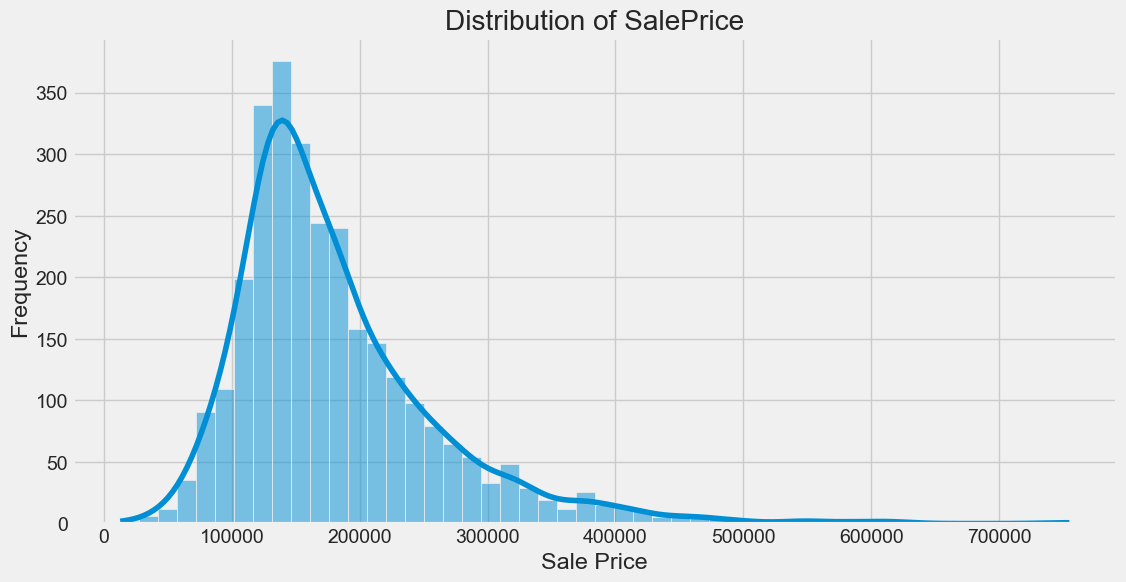

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(data['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

From the above graph we can get notice that the data is right skewed. In simple layman's terms, most of the houses prices are clustered at the lower to mid-price range, but there are a few expensive houses that pull the "tail" of the distribution to the right. Let's print the skewness and kurtosis to get some numbers as well describing this:

In [6]:
print(f"Skewness {data['SalePrice'].skew():.2f}")
print(f"Kurtosis {data['SalePrice'].kurt():.2f}")

Skewness 1.74
Kurtosis 5.12


So the skewness, which measures the asymmetry of the distribution, where a 0 means a perfect symmetric distribution has a positive value here, 1.74. This confirms that the data is right skew as seen in the graph. The further it is from 0 the more skewed it is. Typically, a value larger than one is considered highly skewed

Let's move on the strange looking word, kurtosis. This is just another statistical measure for the tailedness of the distribution and also of whether the distribution is thin or broad. For reference a normal distribution has a kurtosis of 3. A value grater than 3, like we have in our dataset of 5.12, means a couple of things. First this implies a sharper peak, and heavier tails than a normal distribution. If we really want to be fancy, we can say that the distribution is leptokurtic. In this context this means there is a higher probability of extreme values, very cheap or very expensive houses than we would expect in a normal distribution.

So keeping this in mind that the data is highly right-skewed and leptokurtic, means that it would be advisable to apply some kind of transformation to the SalePrice in order to make the distribution more symmetric. Let's try to apply a log transformation and repeat the steps above.

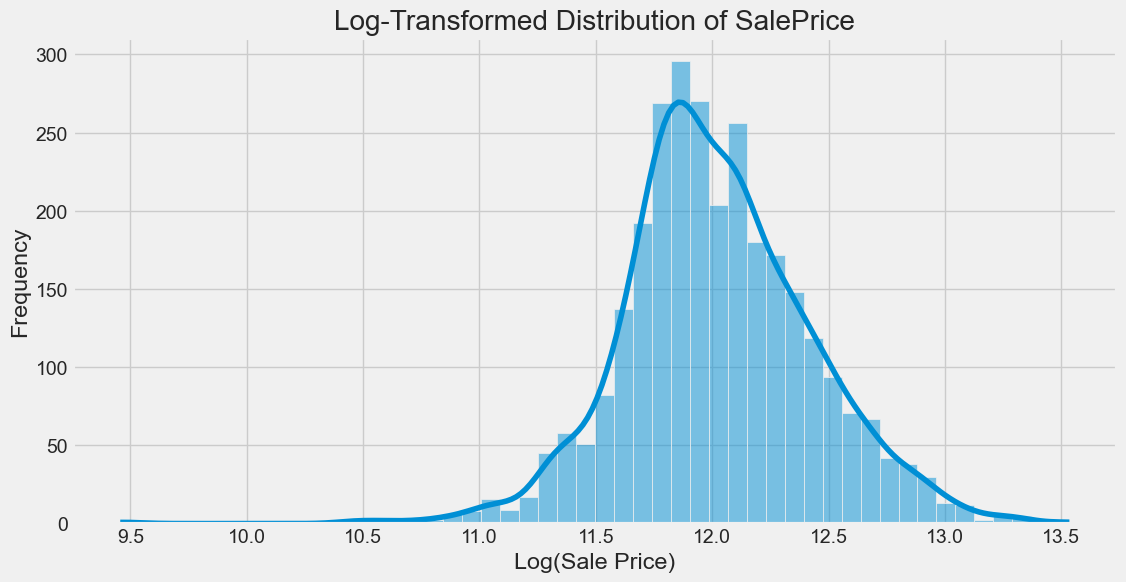

In [7]:
data['SalePrice'] = np.log1p(data['SalePrice'])
plt.figure(figsize=(12, 6))
sns.histplot(data['SalePrice'], kde=True, bins=50)
plt.title('Log-Transformed Distribution of SalePrice')
plt.xlabel('Log(Sale Price)')
plt.ylabel('Frequency')
plt.show()

We can already see that the distribution is significantly improved and is now suitable for models that work with the assumption of normality. The shape resembles a symmetric bell curve, which is the visual representation of normal distribution. The long right tail from the initial distribution is gone.

Let's look over some numbers:

In [8]:
print(f"Skewness {data['SalePrice'].skew():.2f}")
print(f"Kurtosis {data['SalePrice'].kurt():.2f}")

Skewness -0.01
Kurtosis 1.51


The skewness is very close to the perfectly symmetric value 0. This indicates that the right skew has been corrected. The kurtosis has moved from the over 3 normal distribution that it had before, 5.12 , to under, 1.51. We can say it's a bit closer. This value is an indicative of a slightly flatter peak and lighter tails than a perfect distribution. And we have another word for that, Platykurtic.

We can safely say that the log transformation was successful. It corrected the sever right-skew and heavy tails of the original dataset, making the data much more normally distributed. This transformed dataset is more appropriate now for machine learning use.

#### 3. Find key feature relationships

The quickest way to do this is a correlation heatmap. This way we can check which numerical features are most related to the SalePrice target.

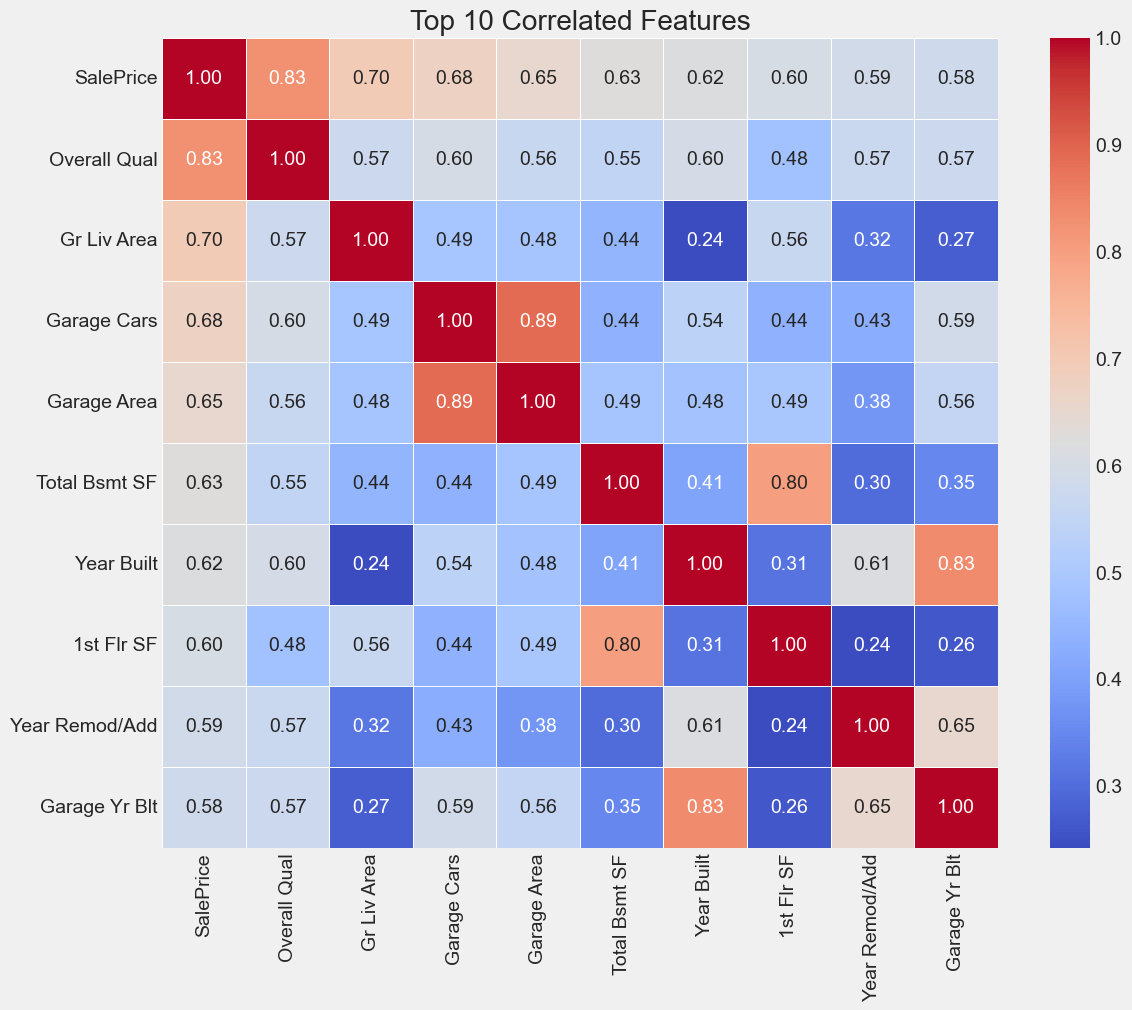

In [10]:
corr = data.corr(numeric_only=True)

top_k = 10
top_k_cols = corr.nlargest(top_k, 'SalePrice')['SalePrice'].index
top_10_corr_matrix = data[top_k_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_10_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title(f'Top {top_k} Correlated Features')
plt.show()

So what does this heatmap tells us?

First, this displays the Pearson correlation coefficients for the top 10 features most strongly related to the SalePrice. The scope here is to identify which features have the strongest linear relationship with the home sale price and to detect multicollinearity among predictor variables. Multicollinearity is a statistical phenomenon in regression models where independent(predictor) variable, are highly correlated with each other, making it difficult to determine the individual effect of each variable on the dependent variable.

If we visually scan the picture, we can see that the strongest predictors are the Overall Qual(0.83) and Gr Liv Area(0.70). We can draw the conclusion that these features have the most significant positive linear relationship with the target variable. The next tier would be Garage Cars(0.68) and Garage Area(0.65).

Now to the multicollinearity issue. There are strong correlations between predictor variables which can pose problems for models like standard Linear Regression. For example:
* Garage Features: Garage Cars and Garage Area have a correlation of 0.89. They are essentially measuring the same thing, garage size
* Year Built Features: Year Built and Garage Yr Blt have a correlation of 0.83. This is expected as garages are built at the same time with the house
* Floor/Basement size: Total Bsmt SF and 1st Flr SF have a correlation of 0.80. This also makes sense as basement size is a strong predictor for the first-floor footprint.

We can notice some Feature Clusters:
* Size Cluster: Gr Liv Area, Garage Area, Total Bsmt SF and 1st Flr SF all have decent correlations between each other
* Age/Renovation Cluster: Year Built with Year Remodd/Add and Garage Yr Blt

What conclusions we can draw from all of this? We can make can get rid of redundant features, for pairs with correlations over 0.80 we should generally remove one in order to avoid multicollinearity issues. We can keep the feature that is more strongly correlated with the target variable, SalePrice:
* Garage Cars(0.68) vs Garage Area(0.65), we can keep Garage Cars and drop Garage Area
* Year Built(0.62) vs Garage Yr Blt(0.58), we can keep Year Built and drop Garage Yr Blt
* Total Bsmt SF(0.63) vs 1st Flr SF(0.60), we can keep Total Bsmt SF and drop 1st Flr SF


#### 4. Visualize Important Features

Let's create some plots for the top features identified in the heatmap, and check their relationship with SalePrice more clearly. We are going to pick the top two features:
* OverallQual, Overall Quality: this is a categorical feature, we have distinct separate values, 1-10. Also, the numbers are a specific ranked order which makes this a categorical ordinal feature. So we are going to choose a box plot
* GrLivArea, above Ground Living Area: this is continuous, in theory we can have a house take any positive value .So a scatter plot sounds like a good plan

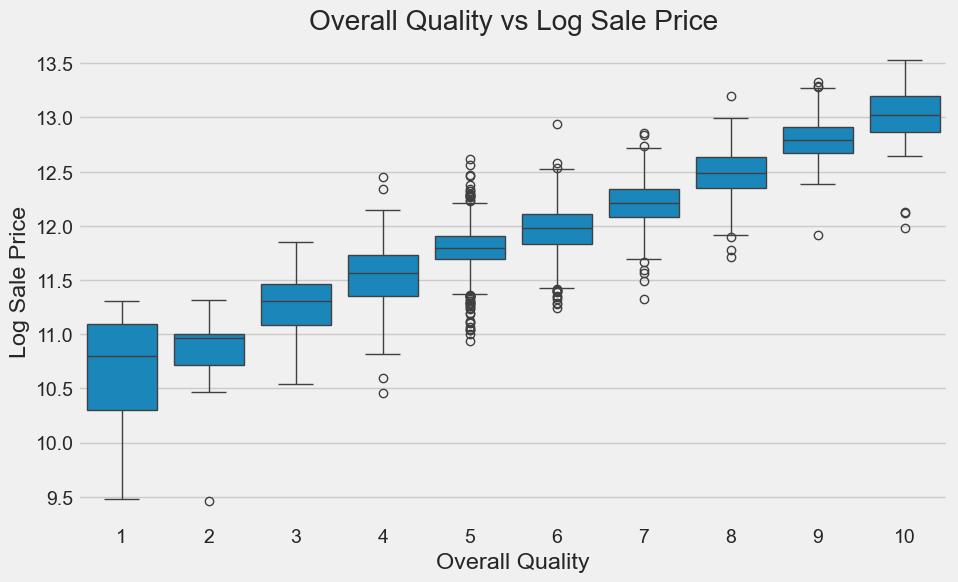

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Overall Qual', y='SalePrice', data=data)
plt.title('Overall Quality vs Log Sale Price')
plt.xlabel('Overall Quality')
plt.ylabel('Log Sale Price')
plt.show()


There's a clear and positive monotonic relationship. As the Overall Quality increases the median for the Log Sale Price increases. The blue boxes represent the middle 50% prices for each quality level, which also moves up as quality improves. Again this is a strong predictor, as a house rated 10 is more likely to have a higher price than a house rated a 5. There are outliers out there, but they don't change the overall trend. For example the lowest values for houses of Quality 8 are lower than the median price for Quality 6.

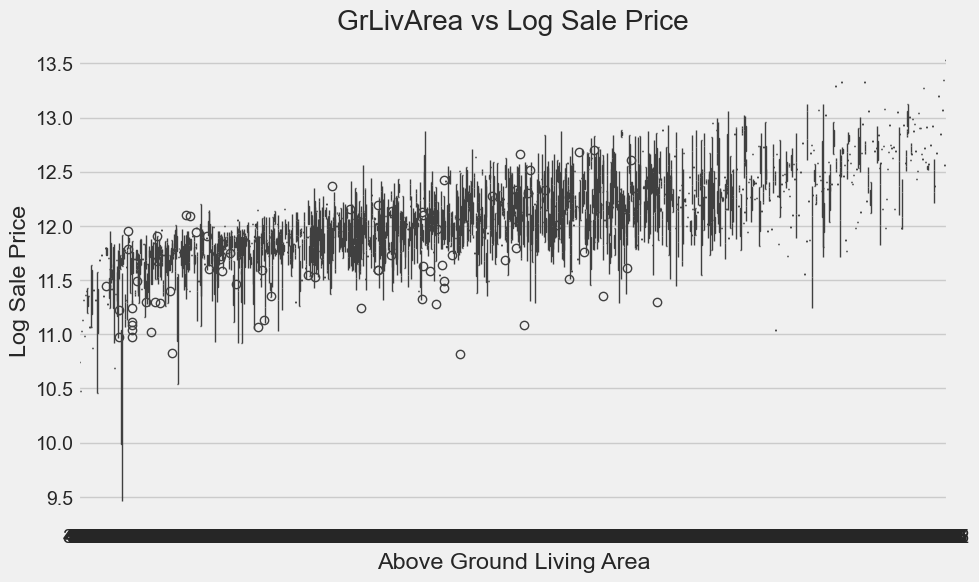

In [16]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='Gr Liv Area', y='SalePrice', data=data)
plt.title('GrLivArea vs Log Sale Price')
plt.xlabel('Above Ground Living Area')
plt.ylabel('Log Sale Price')
plt.show()

This scatter plot shows a clear positive linear relationship between the ground living area and the log sale price. As the living area increases the log sale price tends to increase. While the trend is strong, there's significant noise in the data. This means that houses with the same living area can have very different prices, indicating that other factors come into play.

We can also notice that the variance increases as the living area gets larger. This is a sign of heteroscedasticity, which basically means the variance of the errors(residuals) is not constant across all values of independent variable in a regression model.
